In [2]:
!pip install timm

In [3]:
!pip install torch torchvision scikit-learn pillow

In [4]:
import torch
from torchvision import datasets, transforms
import numpy as np
import timm
from PIL import Image
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
data_dir = 'data'
all_data = datasets.ImageFolder(data_dir)

# Split the data into train, validation, and test sets
train_data_len = int(len(all_data)*0.8)
valid_test_data_len = len(all_data) - train_data_len
valid_data_len = int(valid_test_data_len*0.5)
test_data_len = valid_test_data_len - valid_data_len

train_data, valid_data, test_data = torch.utils.data.random_split(all_data, [train_data_len, valid_data_len, test_data_len])

In [5]:
# Define your transforms with data augmentation for the training set
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Define your transforms for the validation and test sets
valid_test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [6]:
# Apply the transforms to your datasets
train_data.dataset.transform = train_transform
valid_data.dataset.transform = valid_test_transform
test_data.dataset.transform = valid_test_transform

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True)


In [7]:
# Load the pretrained Vision Transformer model
model = timm.create_model('vit_base_patch32_224', pretrained=True, num_classes=5)

In [8]:
# Define the criterion and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Initialize lists to store losses and accuracies for each epoch
train_losses = []
valid_losses = []
train_accs = []
valid_accs = []

# Train the model
for epoch in range(5):  # loop over the dataset multiple times
    model.train()  # Set the model to training mode
    train_loss = 0.0
    train_correct = 0
    for inputs, labels in train_loader:
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        train_correct += (preds == labels).sum().item()

    train_losses.append(train_loss / len(train_loader))
    train_accs.append(train_correct / len(train_loader.dataset))

    # Validate the model
    model.eval()  # Set the model to evaluation mode
    valid_loss = 0.0
    valid_correct = 0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            valid_correct += (preds == labels).sum().item()

    valid_losses.append(valid_loss / len(valid_loader))
    valid_accs.append(valid_correct / len(valid_loader.dataset))

    print('Epoch:', epoch, 'Train Loss:', train_losses[-1], 'Valid Loss:', valid_losses[-1])
    print('Epoch:', epoch, 'Train Accuracy:', train_accs[-1], 'Valid Accuracy:', valid_accs[-1])

print('Finished Training')

Epoch: 0 Train Loss: 1.6476297257868058 Valid Loss: 1.0136509793145316
Epoch: 0 Train Accuracy: 0.32865384615384613 Valid Accuracy: 0.5892307692307692
Epoch: 1 Train Loss: 0.6956000606889373 Valid Loss: 0.3479163093226297
Epoch: 1 Train Accuracy: 0.7261538461538461 Valid Accuracy: 0.8738461538461538
Epoch: 2 Train Loss: 0.3605003147357446 Valid Loss: 0.21425465600831167
Epoch: 2 Train Accuracy: 0.8707692307692307 Valid Accuracy: 0.9323076923076923
Epoch: 3 Train Loss: 0.24251193082405745 Valid Loss: 0.2191704408753486
Epoch: 3 Train Accuracy: 0.9121153846153847 Valid Accuracy: 0.9138461538461539
Epoch: 4 Train Loss: 0.23461658327034646 Valid Loss: 0.21772069962961332
Epoch: 4 Train Accuracy: 0.9157692307692308 Valid Accuracy: 0.9153846153846154
Finished Training


True class: Tomato___Late_blight
Predicted class: Tomato___Late_blight


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


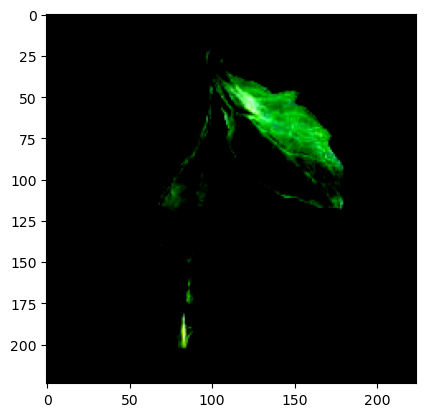

In [10]:
# Get a random batch of images and labels from the test loader
images, labels = next(iter(test_loader))

# Choose a random image from the batch
random_index = torch.randint(len(images), size=(1,)).item()
random_image = images[random_index].unsqueeze(0)
true_label = labels[random_index]

# Use the model to predict the class of the image
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    output = model(random_image)
    _, predicted = torch.max(output, 1)

# Get the class name from the predicted class index
class_names = all_data.classes  # Get the list of class names
predicted_class = class_names[predicted.item()]
true_class = class_names[true_label.item()]

print('True class:', true_class)
print('Predicted class:', predicted_class)

# Display the image
plt.imshow(random_image[0].permute(1, 2, 0))
plt.show()


In [9]:
# Evaluate the model on the test set
model.eval()  # Set the model to evaluation mode
test_loss = 0.0
test_correct = 0
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        test_correct += (preds == labels).sum().item()

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print('Test Loss:', test_loss / len(test_loader))
print('Test Accuracy:', test_correct / len(test_loader.dataset))

Test Loss: 0.2173544636794499
Test Accuracy: 0.9230769230769231


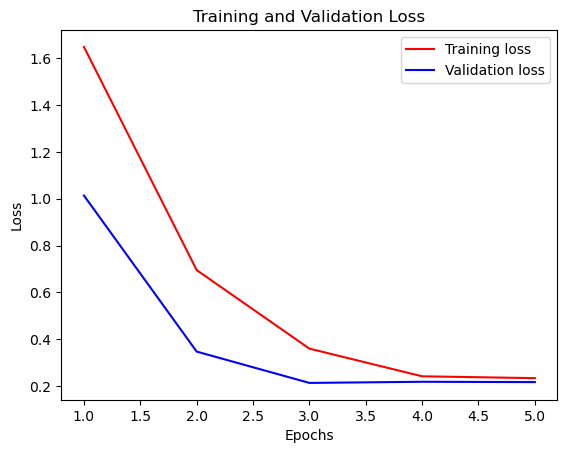

In [11]:
# Generate confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot training and validation loss
plt.figure()
plt.plot(range(1, len(train_losses) + 1), train_losses, 'r', label='Training loss')
plt.plot(range(1, len(valid_losses) + 1), valid_losses, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

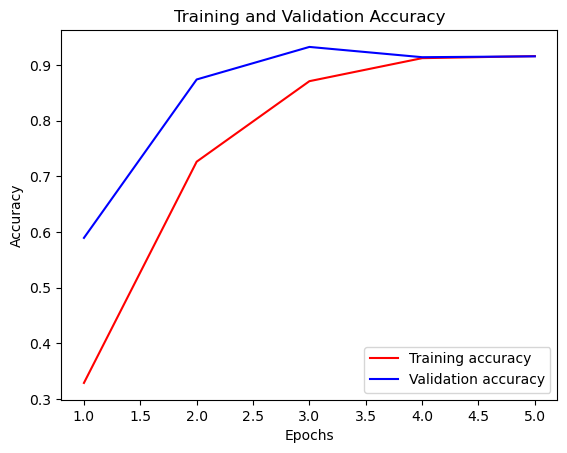

In [12]:

# Plot training and validation accuracy
plt.figure()
plt.plot(range(1, len(train_accs) + 1), train_accs, 'r', label='Training accuracy')
plt.plot(range(1, len(valid_accs) + 1), valid_accs, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [13]:
# Compute ROC curve and ROC area for each class
all_labels_bin = label_binarize(all_labels, classes=np.arange(10))
all_preds_bin = label_binarize(all_preds, classes=np.arange(10))

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(all_labels_bin[:, i], all_preds_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


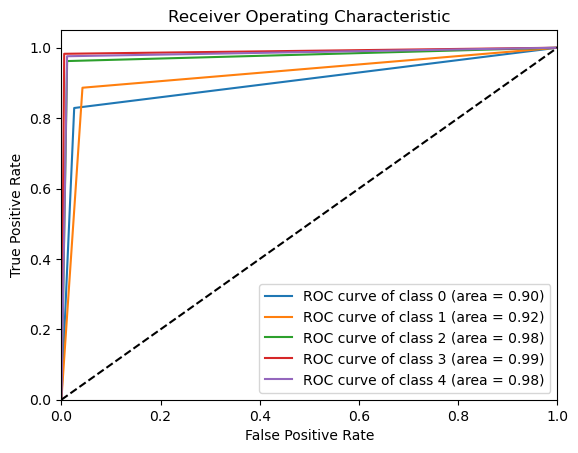

In [14]:
# Plot ROC curve
plt.figure()
for i in range(5):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [16]:
# Compute Precision-Recall and plot curve
precision = dict()
recall = dict()
average_precision = dict()
for i in range(5):
    precision[i], recall[i], _ = precision_recall_curve(all_labels_bin[:, i], all_preds_bin[:, i])
    average_precision[i] = average_precision_score(all_labels_bin[:, i], all_preds_bin[:, i])


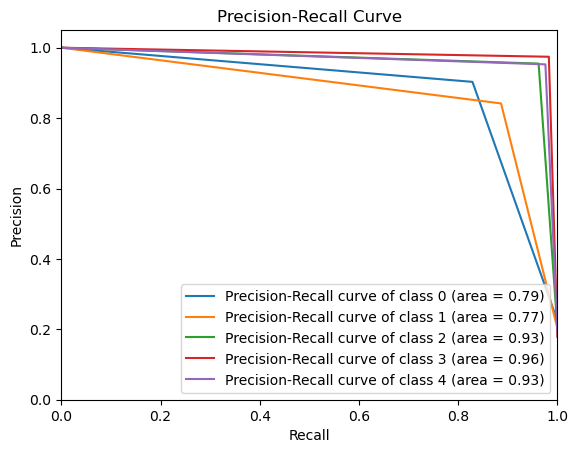

In [17]:
# Plot Precision-Recall curve
plt.figure()
for i in range(5):
    plt.plot(recall[i], precision[i], label='Precision-Recall curve of class {0} (area = {1:0.2f})'.format(i, average_precision[i]))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()